In [205]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import KeyPoint

### Dataset

In [17]:
data=np.load("./olivetti_faces.npy")
target=np.load("./olivetti_faces_target.npy")
print(f"data shape : {data.shape}, target shape : {target.shape}") 

data shape : (400, 64, 64), target shape : (400,)


In [18]:
np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int32)

In [19]:
def imshow_olivetti(data, target):
    plt.figure(figsize=(30, 12))
    idx = 1
    for i in range(0, 400, 10):
        plt.subplot(4, 10, idx)
        plt.title(f"id {idx}")
        idx+=1
        plt.axis('off')
        plt.imshow(data[i], cmap='gray')
    plt.show()

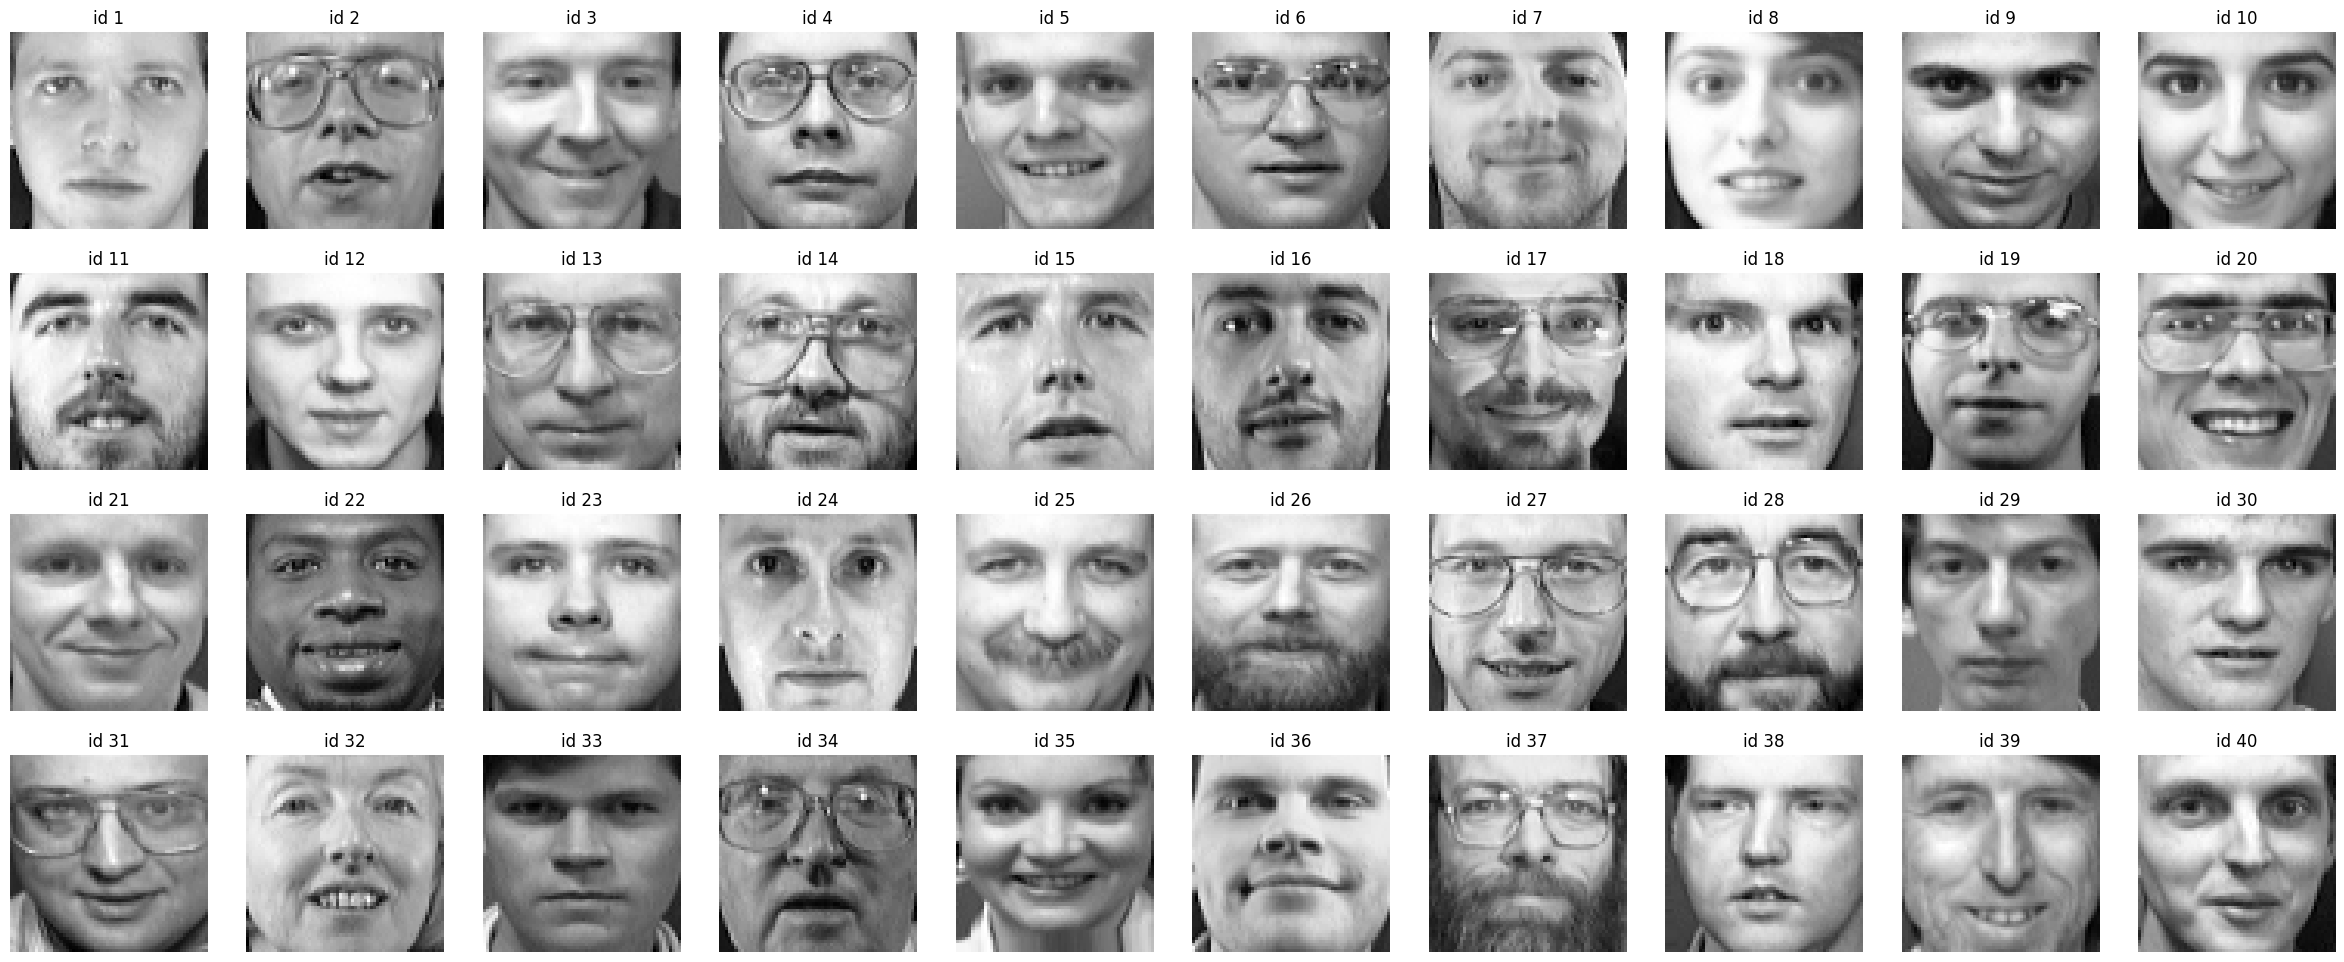

In [20]:
imshow_olivetti(data, target)

Train & Test   
비교를 위해 https://www.kaggle.com/code/jawseph/face-recognition-on-olivetti-dataset 의 split을 따름  
위 링크에서는 약 280 장의 학습 데이터로 머신러닝 모델을 학습하고 약 120 장의 사진에 대한 분류성능을 평가하고 있음  
========== SVM RESULT ==========  
Accuracy score[normal]:0.93  

========== LDA RESULT ==========  
Accuracy score[normal]:0.94  

========== LR RESULT ==========  
Accuracy score[normal]:0.93  

========== NB RESULT ==========  
Accuracy score[normal]:0.88  

========== KNN RESULT ==========  
Accuracy score[normal]:0.69  

========== DT RESULT ==========  
Accuracy score[normal]:0.63  

나는 약 280 장의 데이터 40개 클래스 각각에 대해 7장의 이미지로 테스트 데이터셋과 매칭을 수행하고 최종 클래스를 결정하는 방식을 할 것

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, stratify=target, random_state=0)

In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(280, 64, 64) (120, 64, 64) (280,) (120,)


1 vs 1 matching with sift

In [27]:
image = X_train[0]
image.shape, image.dtype

((64, 64), dtype('float32'))

In [40]:
# assignment3
def gaussian_filter(sigma):
    filter_size = int(2 * np.ceil(3 * sigma) + 1)
    filter = np.zeros((filter_size, filter_size), dtype=np.float32)
    k = filter_size // 2
    s = 0.0
    for i in range(filter_size):
        for j in range(filter_size):
            filter[i, j] = np.exp(-0.5 * ((i - k)**2 + (j - k)**2) / sigma**2)
            s += filter[i, j]
    # normalize
    filter /= s
    return filter, filter_size
    
def ImageSmoothing(f, sigma):
    '''
    input
    f : input
    sigma : standard deviation of the Gaussian filter
    output
    g : output image
    filter size -> (-3*sigma, +3*sigma)
    '''
    filter, filter_size = gaussian_filter(sigma)
    h, w = f.shape
    pad = filter_size//2
    f_pad = np.pad(f, pad, mode='constant', constant_values=0)
    g = np.zeros_like(f, dtype=np.float32)
    for i in range(h):
        for j in range(w):
            g[i, j] = np.sum(filter * f_pad[i:i + filter_size, j:j + filter_size])
    return g

### Detection of scale-space extrema

In [557]:
sigma = 1.6
image = X_train[0].copy()
image2 = ImageSmoothing(cv2.resize(image,(0, 0), fx=2, fy=2), sigma)

num_octaves = 6
num_intervals = 3
num_images_per_octaves = num_intervals+3
k = 2**(1./num_intervals)

gaussian_filters = np.zeros(num_images_per_octaves)
gaussian_filters[0] = sigma

for img_idx in range(1, num_images_per_octaves):
    sigma_prev = (k**(img_idx-1))*sigma
    sigma_tot = k*sigma_prev
    gaussian_filters[img_idx] = np.sqrt(sigma_tot **2 - sigma_prev **2)
print(gaussian_filters)

gaussian_images = []
for octave_index in range(num_octaves):
    gaussian_images_in_octave = []
    gaussian_images_in_octave.append(image2)  # first image in octave already has the correct blur
    for gaussian_kernel in gaussian_filters[1:]:
        image2 = ImageSmoothing(image2, sigma=gaussian_kernel)
        gaussian_images_in_octave.append(image2)
    gaussian_images.append(gaussian_images_in_octave)
    octave_base = gaussian_images_in_octave[-3]
    image2 = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
# plt.imshow(image2, cmap='gray')
# plt.show()
# plt.imshow(image, cmap='gray')
# plt.show()

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [558]:

len(gaussian_images), len(gaussian_images[0]), gaussian_images[0][0].shape, gaussian_images[1][0].shape

(6, 6, (128, 128), (64, 64))

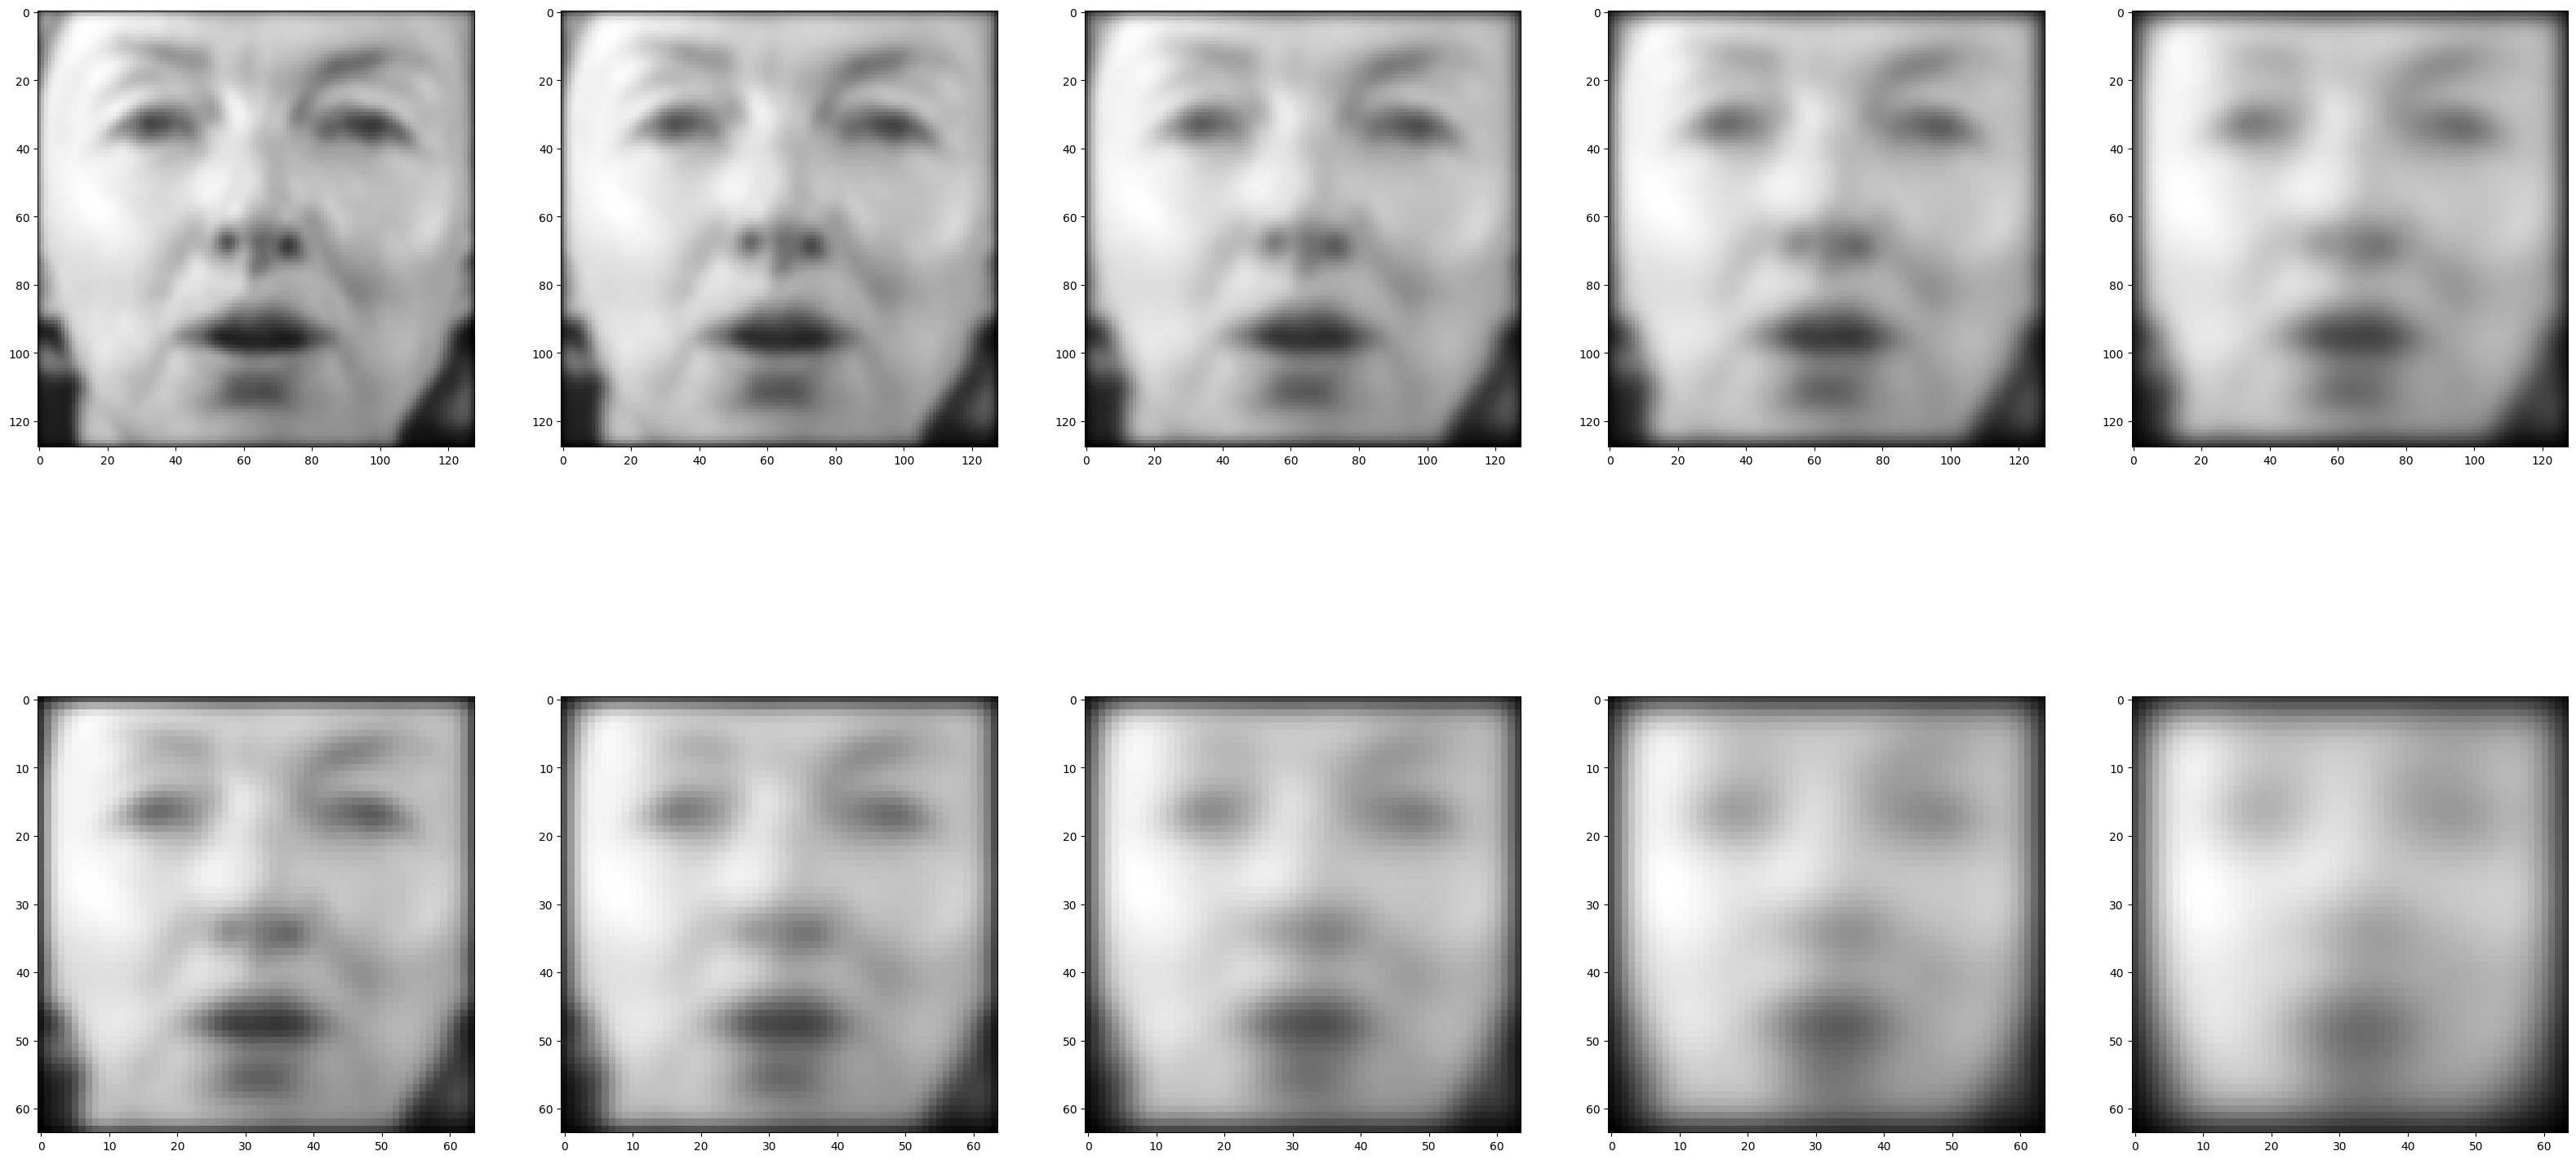

In [559]:
plt.figure(figsize=(40, 20))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(gaussian_images[0][i], cmap='gray')
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(gaussian_images[1][i], cmap='gray')

plt.savefig('/home/vcl/Desktop/final_project/fig2.png', bbox_inches='tight')
    

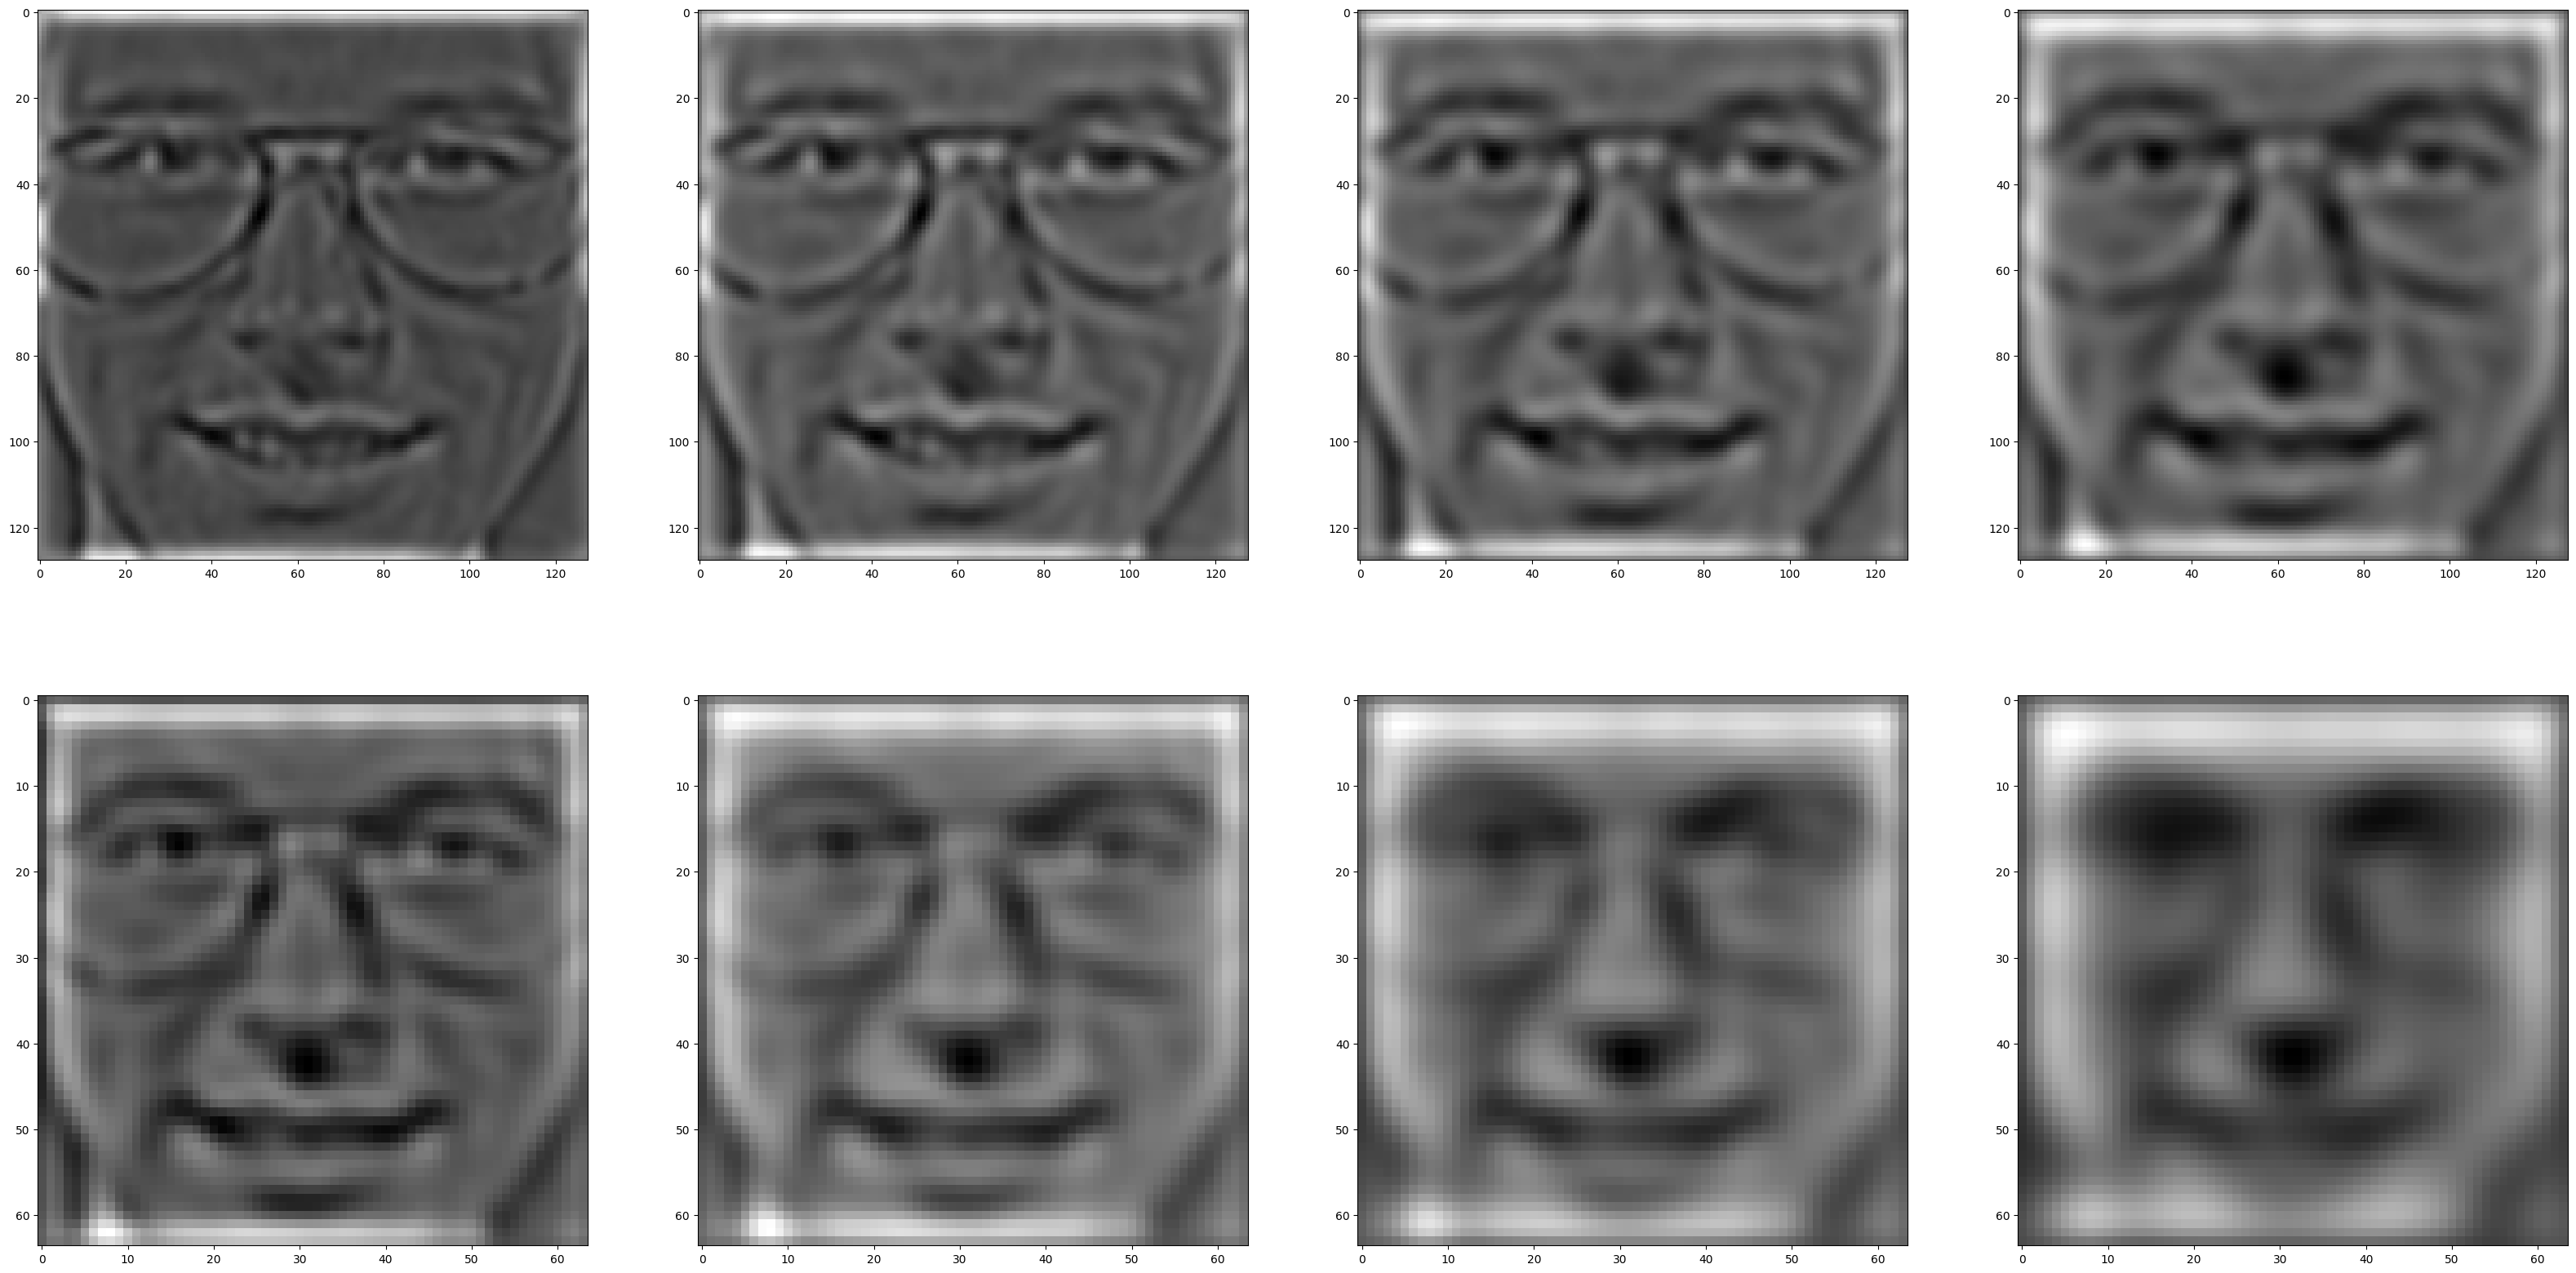

In [560]:
plt.figure(figsize=(40, 20))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(dog_images[0][i], cmap='gray')
for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.imshow(dog_images[1][i], cmap='gray')
plt.savefig('/home/vcl/Desktop/final_project/fig3.png', bbox_inches='tight')

In [417]:
len(dog_images), len(dog_images[0])

(6, 5)

In [418]:
def detect_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    threshold = np.floor(0.5 * contrast_threshold / num_intervals)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            try:
                                keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                                for keypoint_with_orientation in keypoints_with_orientations:
                                    keypoints.append(keypoint_with_orientation)
                            except:
                                continue
    return keypoints



def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if np.abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return np.all(center_pixel_value >= first_subimage) and \
                   np.all(center_pixel_value >= third_subimage) and \
                   np.all(center_pixel_value >= second_subimage[0, :]) and \
                   np.all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return np.all(center_pixel_value <= first_subimage) and \
                   np.all(center_pixel_value <= third_subimage) and \
                   np.all(center_pixel_value <= second_subimage[0, :]) and \
                   np.all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

In [419]:
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = np.stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))

        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = cv2.KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return np.array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return np.array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

In [420]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape
    float_tolerance = 1e-12
    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [421]:
def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

In [425]:
def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    descriptors = []
    float_tolerance = 1e-9
    for keypoint in keypoints:
        
        octave, layer, scale = unpackOctave(keypoint)
        try:
            gaussian_image = gaussian_images[octave + 1][layer]##33
        except:
            continue
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

In [516]:
from functools import cmp_to_key


sigma = 1.6
image = X_train[1].copy()
image2 = ImageSmoothing(cv2.resize(image,(0, 0), fx=2, fy=2), sigma)

num_octaves = 6
num_intervals = 3
num_images_per_octaves = num_intervals+3
k = 2**(1./num_intervals)

gaussian_filters = np.zeros(num_images_per_octaves)
gaussian_filters[0] = sigma

for img_idx in range(1, num_images_per_octaves):
    sigma_prev = (k**(img_idx-1))*sigma
    sigma_tot = k*sigma_prev
    gaussian_filters[img_idx] = np.sqrt(sigma_tot **2 - sigma_prev **2)
print(gaussian_filters)

gaussian_images = []
for octave_index in range(num_octaves):
    gaussian_images_in_octave = []
    gaussian_images_in_octave.append(image2)  # first image in octave already has the correct blur
    for gaussian_kernel in gaussian_filters[1:]:
        image2 = ImageSmoothing(image2, sigma=gaussian_kernel)
        gaussian_images_in_octave.append(image2)
    gaussian_images.append(gaussian_images_in_octave)
    octave_base = gaussian_images_in_octave[-3]
    image2 = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)

dog_images = []
for gaussian_images_in_octave in gaussian_images:
    dog_images_in_octave = []
    for img1, img2 in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
        dog_images_in_octave.append(img1-img2)
    dog_images.append(dog_images_in_octave)
keypoints = detect_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma,5 , 0.0001)
keypoints = removeDuplicateKeypoints(keypoints)
keypoints = convertKeypointsToInputImageSize(keypoints)
descriptors = generateDescriptors(keypoints, gaussian_images)

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [522]:
sigma = 1.6
image_t = X_train[4].copy()
image2 = ImageSmoothing(cv2.resize(image_t,(0, 0), fx=2, fy=2), sigma)

num_octaves = 6
num_intervals = 3
num_images_per_octaves = num_intervals+3
k = 2**(1./num_intervals)

gaussian_filters = np.zeros(num_images_per_octaves)
gaussian_filters[0] = sigma

for img_idx in range(1, num_images_per_octaves):
    sigma_prev = (k**(img_idx-1))*sigma
    sigma_tot = k*sigma_prev
    gaussian_filters[img_idx] = np.sqrt(sigma_tot **2 - sigma_prev **2)
print(gaussian_filters)

gaussian_images = []
for octave_index in range(num_octaves):
    gaussian_images_in_octave = []
    gaussian_images_in_octave.append(image2)  # first image in octave already has the correct blur
    for gaussian_kernel in gaussian_filters[1:]:
        image2 = ImageSmoothing(image2, sigma=gaussian_kernel)
        gaussian_images_in_octave.append(image2)
    gaussian_images.append(gaussian_images_in_octave)
    octave_base = gaussian_images_in_octave[-3]
    image2 = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)

dog_images = []
for gaussian_images_in_octave in gaussian_images:
    dog_images_in_octave = []
    for img1, img2 in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
        dog_images_in_octave.append(img1-img2)
    dog_images.append(dog_images_in_octave)
keypoints_t = detect_scale_space_extrema(gaussian_images, dog_images, num_intervals, sigma, 5 , 0.0001)
keypoints_t = removeDuplicateKeypoints(keypoints_t)
keypoints_t = convertKeypointsToInputImageSize(keypoints_t)
descriptors_t = generateDescriptors(keypoints_t, gaussian_images)

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [523]:
kp1 = keypoints
des1 = descriptors
kp2 = keypoints_t
des2 = descriptors_t
img1 = image
img2 = image_t

In [524]:
len(kp1), len(kp2), len(des1), len(des2)

(74, 71, 73, 71)

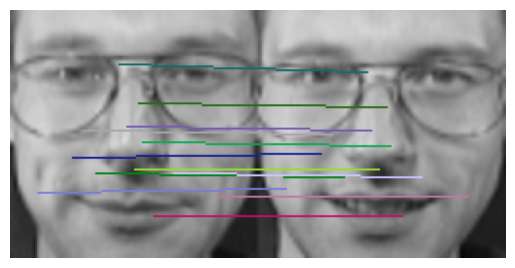

In [544]:

# Initialize and use FLANN
MIN_MATCH_COUNT = 5
FLANN_INDEX_KDTREE = 0
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)


if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    # img1 = cv2.cvtColor(img1, cv2.GRAY2RGB)
    # img2 = cv2.cvtColor(img2, cv2.GRAY2RGB)
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.float32)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2
    
    newimg = ((1-newimg)*255).astype(np.uint8)
    # newimg = cv2.cvtColor(newimg, cv2.COLOR_GRAY2RGB)
    newimg = cv2.resize(newimg, (0, 0), fx=2, fy=2)
    
    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0])*2, int(kp1[m.queryIdx].pt[1] + hdif)*2)
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1)*2, int(kp2[m.trainIdx].pt[1])*2)
        color = [np.random.randint(0, 255) for _ in range(3)]
        cv2.line(newimg, pt1, pt2, color, 1)
    plt.axis(False)
    plt.imshow(newimg)
    plt.savefig('/home/vcl/Desktop/final_project/fig4.png',bbox_inches='tight')
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))

1. Scale-space extrema detection
2. Keypoint localization
3. orientation assignment
4. Keypoint desciptor

In [545]:
sift = cv2.SIFT_create()
#https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
img1 = cv2.resize((X_train[1]*255).astype(np.uint8), (0, 0), fx=2, fy=2)
img2 = cv2.resize((X_train[4]*255).astype(np.uint8), (0, 0), fx=2, fy=2)
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

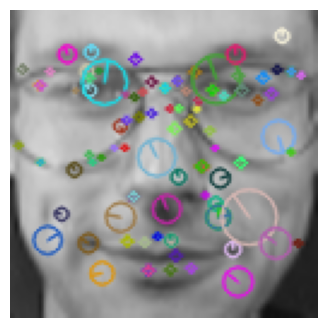

In [555]:
# img_result = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_result = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(4,4))
plt.axis(False)
plt.imshow(img_result)
plt.savefig('/home/vcl/Desktop/final_project/fig5.png', bbox_inches='tight')

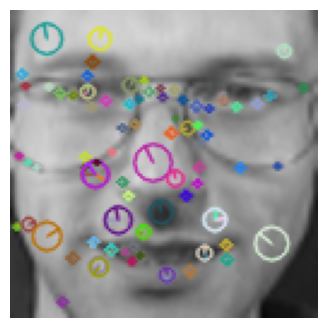

In [556]:
# img_result = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_result = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(4,4))
plt.axis(False)
plt.imshow(img_result)
plt.savefig('/home/vcl/Desktop/final_project/fig6.png', bbox_inches='tight')

In [537]:
des1.shape

(56, 128)

In [476]:
des2.shape

(59, 128)

In [497]:
matches2 = []
for i, x in enumerate(des1):
    nx1 = (x-x.min())/(x.max()- x.min())
    temp = []
    for j, x2 in enumerate(des2):
        nx2 = (x2-x2.min())/(x2.max()- x2.min())
        dist = np.matmul(nx1, nx2)
        temp.append((dist, j))
    temp.sort(key=lambda x: x[0])
    temp[-2:][::-1]
    matches2.append(temp[-2:])

In [499]:
good = []
for m, n in matches2:
    if m[0] < 0.75*n[0]:
        good.append([m])